In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 31.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [3]:
!pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 72.6 MB/s eta 0:00:00


**Import Libraries**



In [4]:
import cv2
import numpy as np
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import os
from math import hypot
import torch
import torchvision.transforms as transforms
from torchvision.models import resnet18
from sklearn.metrics.pairwise import cosine_similarity

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


**Initialization**

In [5]:
video_path = "/content/15sec_input_720p.mp4"
model_path = "/content/best.pt"
model = YOLO(model_path)
tracker = DeepSort(max_age=30, n_init=3)

cap = cv2.VideoCapture(video_path)
width, height = int(cap.get(3)), int(cap.get(4))
fps = cap.get(cv2.CAP_PROP_FPS)
out = cv2.VideoWriter('output.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))


In [6]:
# Data structures for analysis
player_tracks = defaultdict(list)
heatmap = np.zeros((height, width), dtype=np.float32)
unique_ids = set()
player_speeds = defaultdict(list)
player_embeddings = {}
passes = []
frame_idx = 0

In [7]:
# Appearance-based Re-ID model
device = "cuda" if torch.cuda.is_available() else "cpu"
reid_model = resnet18(pretrained=True).eval().to(device)
extract_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

def get_embedding(crop):
    tensor = extract_transform(crop).unsqueeze(0).to(device)
    with torch.no_grad():
        return reid_model(tensor).cpu().numpy().flatten()

def match_id(crop, known_embeddings, threshold=0.8):
    emb = get_embedding(crop).reshape(1, -1)
    best_id, best_score = None, 0
    for pid, ref_emb in known_embeddings.items():
        sim = cosine_similarity(emb, ref_emb.reshape(1, -1))[0][0]
        if sim > best_score and sim > threshold:
            best_id = pid
            best_score = sim
    return best_id


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


**Frame Loop**

In [8]:
if not os.path.exists("snapshots"):
    os.makedirs("snapshots")

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1

    results = model(frame)[0]
    detections = []
    ball_position = None

    for r in results.boxes.data.tolist():
        x1, y1, x2, y2, score, cls = r
        cls = int(cls)
        bbox = [x1, y1, x2 - x1, y2 - y1]
        if cls == 0:  # player
            detections.append((bbox, score, 'player'))
        elif cls == 1:  # ball
            cx, cy = int((x1 + x2)/2), int((y1 + y2)/2)
            ball_position = (cx, cy)
            cv2.circle(frame, (cx, cy), 7, (0, 0, 255), -1)
            cv2.putText(frame, 'Ball', (cx + 10, cy), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    tracks = tracker.update_tracks(detections, frame=frame)

    for track in tracks:
        if not track.is_confirmed():
            continue

        track_id = track.track_id
        l, t, r, b = map(int, track.to_ltrb())
        cx = int((l + r) / 2)
        cy = int((t + b) / 2)

        # Re-ID embedding
        crop = frame[t:b, l:r]
        if crop.size > 0:
            emb = get_embedding(crop)
            player_embeddings[track_id] = emb

        # Track and heatmap
        unique_ids.add(track_id)
        player_tracks[track_id].append((cx, cy))
        heatmap[cy, cx] += 1

        # Speed estimation
        if len(player_tracks[track_id]) >= 2:
            x1, y1 = player_tracks[track_id][-2]
            x2, y2 = player_tracks[track_id][-1]
            dist = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            speed = dist * fps
            player_speeds[track_id].append(speed)
            cv2.putText(frame, f'{speed:.1f}px/s', (l, b + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 100, 255), 2)

        # Pass detection
        if ball_position:
            distance = hypot(ball_position[0] - cx, ball_position[1] - cy)
            if distance < 50:
                passes.append((frame_idx, track_id))
                cv2.putText(frame, "Pass!", (cx, cy - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 255), 2)

        # Draw
        cv2.rectangle(frame, (l, t), (r, b), (0, 255, 0), 2)
        cv2.putText(frame, f'Player {track_id}', (l, t - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Snapshot
        if frame_idx == 100 and crop.size > 0:
            cv2.imwrite(f"snapshots/player_{track_id}_f{frame_idx}.jpg", crop)

    out.write(frame)

cap.release()
out.release()


0: 384x640 1 ball, 16 players, 2 referees, 66.5ms
Speed: 10.0ms preprocess, 66.5ms inference, 255.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 18 players, 2 referees, 55.5ms
Speed: 3.6ms preprocess, 55.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 55.5ms
Speed: 2.7ms preprocess, 55.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 54.4ms
Speed: 3.3ms preprocess, 54.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 14 players, 2 referees, 35.5ms
Speed: 2.3ms preprocess, 35.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 ball, 16 players, 2 referees, 35.3ms
Speed: 2.6ms preprocess, 35.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 15 players, 2 referees, 35.3ms
Speed: 2.3ms preprocess, 35.3ms inference, 1.5ms postprocess per image at 


 Tracking Complete: 15 unique players re-identified.


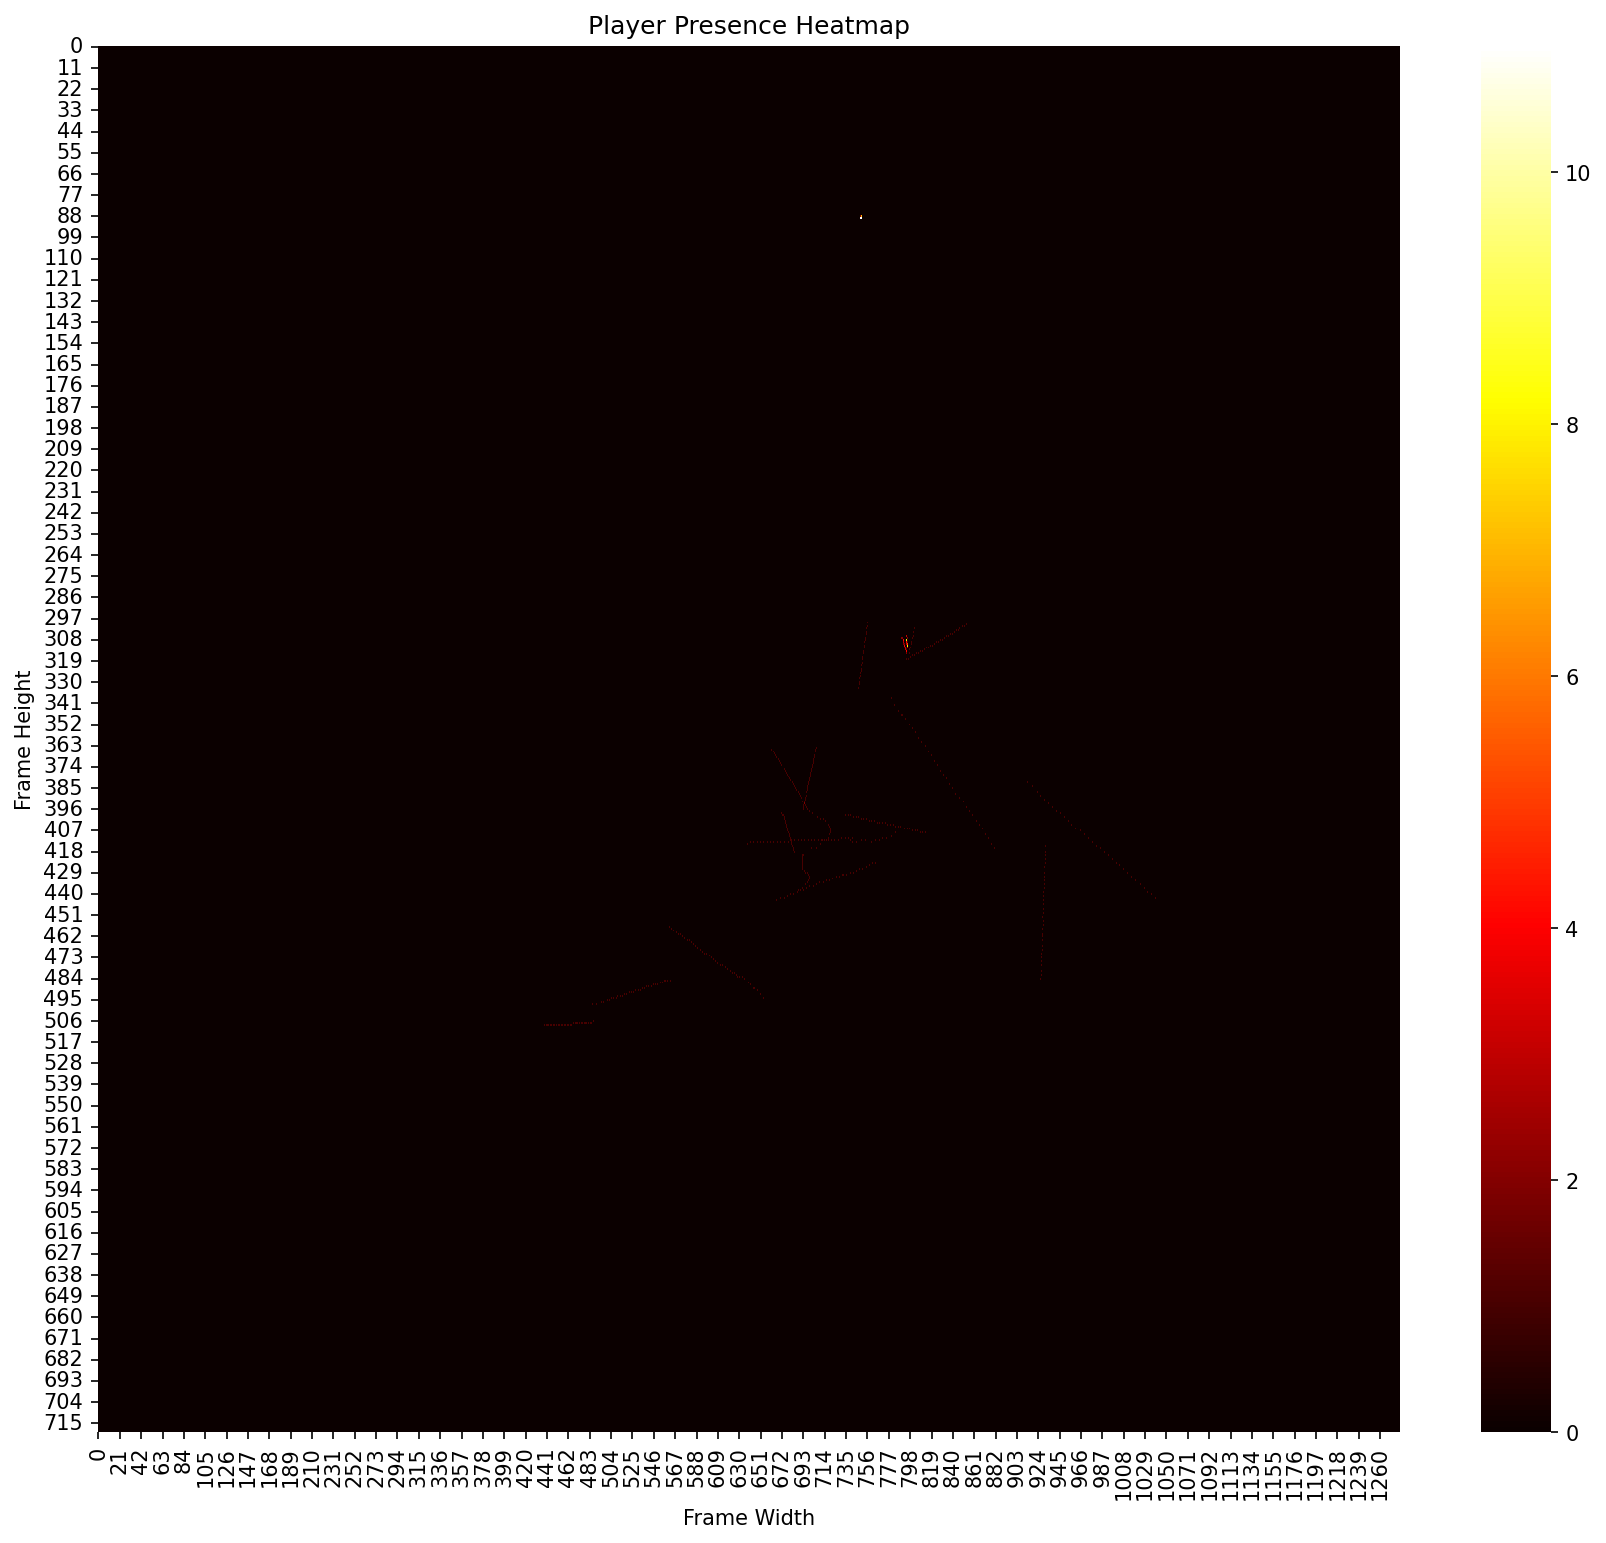

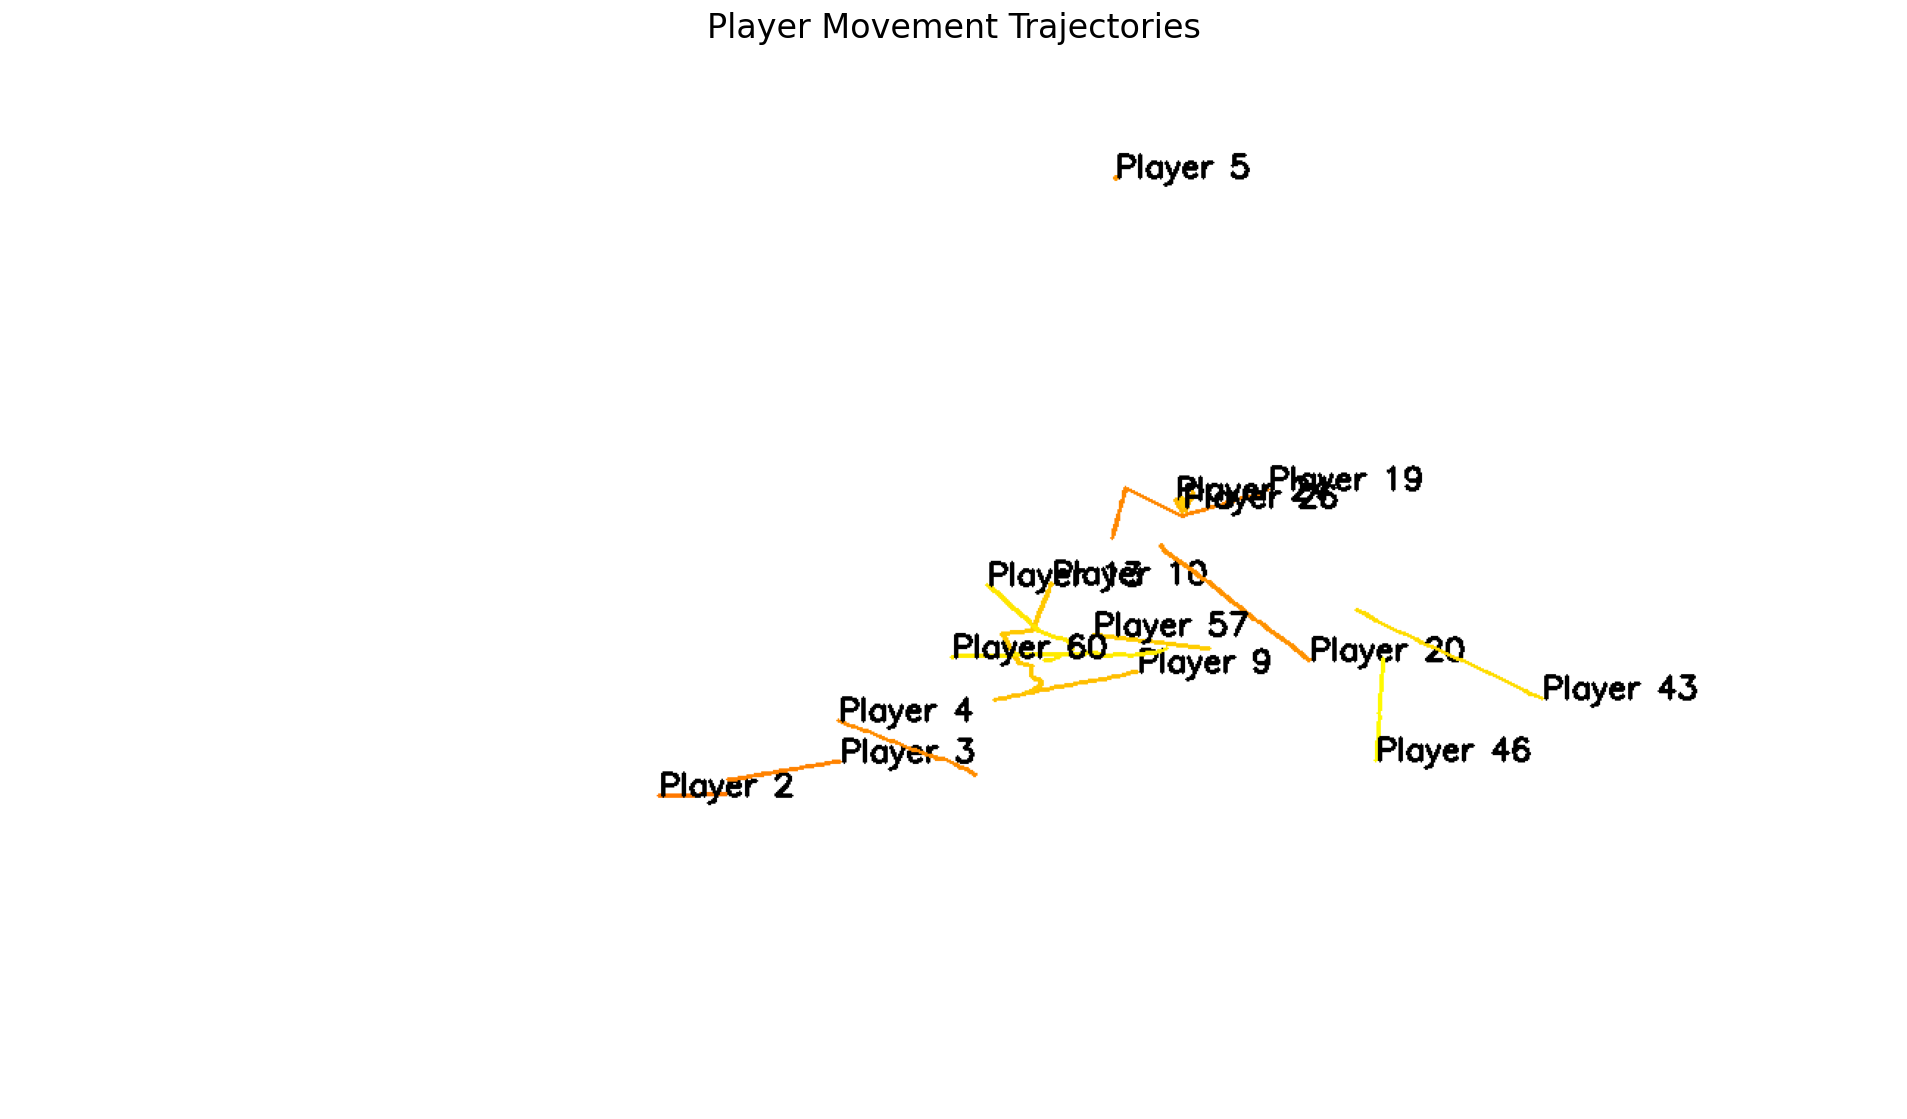

 Player 2 Avg Speed: 39.09 px/s
 Player 3 Avg Speed: 61.45 px/s
 Player 4 Avg Speed: 62.07 px/s
 Player 5 Avg Speed: 4.51 px/s
 Player 9 Avg Speed: 83.24 px/s
 Player 10 Avg Speed: 43.23 px/s
 Player 13 Avg Speed: 51.68 px/s
 Player 19 Avg Speed: 66.17 px/s
 Player 20 Avg Speed: 100.33 px/s
 Player 24 Avg Speed: 26.42 px/s
 Player 26 Avg Speed: 6.83 px/s
 Player 43 Avg Speed: 109.43 px/s
 Player 46 Avg Speed: 55.20 px/s
 Player 57 Avg Speed: 67.17 px/s
 Player 60 Avg Speed: 87.21 px/s

 Video saved as output.mp4
 Heatmap and trajectories generated.
 Total unique players detected: 15
 Total passes detected: 0


In [9]:
#Analysis Plots
print(f"\n Tracking Complete: {len(unique_ids)} unique players re-identified.")

plt.figure(figsize=(14, 12), dpi=150)
sns.heatmap(heatmap, cmap='hot')
plt.title('Player Presence Heatmap')
plt.xlabel("Frame Width")
plt.ylabel("Frame Height")
plt.show()

blank = np.ones((height, width, 3), dtype=np.uint8) * 255
for track_id, positions in player_tracks.items():
    # Convert track_id to integer for color calculation
    numeric_track_id = int(track_id)
    for i in range(1, len(positions)):
        # Use the numeric_track_id for calculation
        cv2.line(blank, positions[i-1], positions[i], (0, 100 + (numeric_track_id*10) % 155, 255), 2)
    cv2.putText(blank, f"Player {track_id}", positions[-1], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,0), 2)

plt.figure(figsize=(16, 14), dpi=120)
plt.imshow(cv2.cvtColor(blank, cv2.COLOR_BGR2RGB))
plt.title("Player Movement Trajectories", fontsize=20)
plt.axis("off")
plt.tight_layout()
plt.show()

for pid, speeds in player_speeds.items():
    if speeds:
        avg_speed = np.mean(speeds)
        print(f" Player {pid} Avg Speed: {avg_speed:.2f} px/s")

print("\n Video saved as output.mp4")
print(" Heatmap and trajectories generated.")
print(f" Total unique players detected: {len(unique_ids)}")
print(f" Total passes detected: {len(passes)}")